# Context

The goal of this analysis is to estimate the impact the Volkswagen emissions scandal had on their stock price. To estimate the impact, I build a counterfactual using other stocks that correlate with the Volkswagen stock in the time before the scandal (pre period). The counterfactual is a synthetic control and will be compared to the empirical Volkswagen data in the time after the scandal (post period). The notebook includes data preprocessing, exploratory data analysis, and time series forecasting, and there is a summary of findings at the end.

More context around the Volkswagen emissions scandal: Volkswagen admitted deceiving the public about their vehicle emissions on 9/20/2015. "The agency (United States Environmental Protection Agency) had found that Volkswagen had intentionally programmed turbocharged direct injection (TDI) diesel engines to activate their emissions controls only during laboratory emissions testing, which caused the vehicles' NOx output to meet US standards during regulatory testing, while they emitted up to 40 times more NOx in real-world driving. Volkswagen deployed this software in about 11 million cars worldwide, including 500,000 in the United States, in model years 2009 through 2015."

Libraries

In [32]:
!pip install CausalImpact

[*****                 10%                       ]  174 of 1811 completedLooking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*****                 10%                       ]  176 of 1811 completedRequirement already satisfied: cloudpickle in /usr/local/lib/python3.9/dist-packages (from pymc->CausalImpact) (2.2.1)
[*****                 10%                       ]  177 of 1811 completedRequirement already satisfied: toolz in /usr/local/lib/python3.9/dist-packages (from logical-unification->pytensor->CausalImpact) (0.12.0)
[******                12%                       ]  216 of 1811 completed

In [33]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from prophet import Prophet
from causalimpact import CausalImpact
import os
pd.set_option('display.max_columns', None)

In [34]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/Varmai/Data-sets/main/nyse_stock_ticker_symbols.csv')

[******                12%                       ]  218 of 1811 completed

In [35]:
raw_df.head()

,Unnamed: 0,stocks
0,0,A
1,1,AA
2,2,AAP
3,3,AAT
4,4,AB


In [36]:
pre_period = [pd.to_datetime('2010-1-1'), pd.to_datetime('2015-9-19')]
post_period = [pd.to_datetime('2015-9-20'), pd.to_datetime('2015-12-31')]

* Pre period is before the scandal

* Post period is after the scandal

In [37]:
# Stocks traded on the NYSE (will be used to build counterfactual)
raw_df.drop('Unnamed: 0', axis=1, inplace=True)
stocks = list(raw_df['stocks'].values)
print(f'Number of ticker symbols in the list: {len(stocks):,.0f}')

Number of ticker symbols in the list: 1,811


The code below takes about 5-10 minutes to run. It downloads 5 years of stock market data for 1800 companies from Yahoo Finance.

In [ ]:
# Use the Yahoo Finance library to get the stock price data
stock_data = yf.download(start = pre_period[0], end = post_period[1], tickers=stocks)

# Select just the adjusted close column for each ticker
adj_close = stock_data.loc[:,'Adj Close']

# Format the index as a pandas date object
adj_close.index = pd.to_datetime(adj_close.index)

# Preprocessing

Filtering data to remove stocks with more than 100 days with no data.

In [40]:
# Remove stocks with more than 100 days with no data
count_na = adj_close.isna().sum().sort_values()
keep_stocks = count_na[count_na < 100]
adj_close = adj_close[keep_stocks.index]

# Print how many stocks are left after removing nans
num_stocks_left = len(adj_close.columns)
print(f'There are {num_stocks_left:,.0f} stocks left after removing nans')

There are 1,356 stocks left after removing nans


**Fix missing dates**

The dataset from Yahoo Finance skips dates with no stock market trading. Missing dates will cause issues with the time series forecasting models used later in the notebook.

In [41]:
# Create a dataframe with the complete date range
full_dates = pd.date_range(start = pre_period[0], end = post_period[1])
full_dates = pd.DataFrame(full_dates, columns=['full_dates'])

# Left join the stock data to the dataframe with the complete date range
adj_close = full_dates.merge(adj_close, left_on='full_dates', right_index=True, how='left')

# Put the date in the index
adj_close.set_index('full_dates', inplace=True)

print('Shape of data after fixing missing dates:', adj_close.shape)

Shape of data after fixing missing dates: (2191, 1356)


In [42]:
adj_close

A        MXF        MXE       MWA        MVT       MVO  \
full_dates                                                                   
2010-01-01        NaN        NaN        NaN       NaN        NaN       NaN   
2010-01-02        NaN        NaN        NaN       NaN        NaN       NaN   
2010-01-03        NaN        NaN        NaN       NaN        NaN       NaN   
2010-01-04  20.434929   9.431811   6.327004  4.500381   6.702601  5.193464   
2010-01-05  20.212959   9.541288   6.359326  4.467289   6.702601  5.296596   
...               ...        ...        ...       ...        ...       ...   
2015-12-27        NaN        NaN        NaN       NaN        NaN       NaN   
2015-12-28  39.591709  13.241942  10.599607  7.816961  11.743720  2.326893   
2015-12-29  40.141327  13.186834  10.629161  7.898296  11.837785  2.271599   
2015-12-30  39.961281  12.966396  10.540502  7.816961  11.888436  2.110330   
2015-12-31        NaN        NaN        NaN       NaN        NaN       NaN   

                  MUR        MUJ        MUI       MUE        MUC        MUA  \
full_dates                                                                    
2010-01-01        NaN        NaN        NaN       NaN        NaN        NaN   
2010-01-02        NaN        NaN        NaN       NaN        NaN        NaN   
2010-01-03        NaN        NaN        NaN       NaN        NaN        NaN   
2010-01-04  31.663195   6.945591   6.980244  6.513521   6.597368   6.420234   
2010-01-05  32.178471   6.970963   6.990876  6.508520   6.602595   6.483541   
...               ...        ...        ...       ...        ...        ...   
2015-12-27        NaN        NaN        NaN       NaN        NaN        NaN   
2015-12-28  17.619333  10.421508  10.838882  9.929007  11.164662  10.773746   
2015-12-29  17.863497  10.450802  10.792984  9.906977  11.126894  10.841600   
2015-12-30  17.288528  10.524040  10.838882  9.958385  11.187325  10.796365   
2015-12-31        NaN        NaN        NaN       NaN        NaN        NaN   

                  MTZ        MTX        MTW       MTRN        MTR         MTN  \
full_dates                                                                      
2010-01-01        NaN        NaN        NaN        NaN        NaN         NaN   
2010-01-02        NaN        NaN        NaN        NaN        NaN         NaN   
2010-01-03        NaN        NaN        NaN        NaN        NaN         NaN   
2010-01-04  13.120000  26.739090   8.977180  17.805441  13.942924   29.727957   
2010-01-05  12.850000  26.638367   9.639925  18.223104  13.742441   29.785009   
...               ...        ...        ...        ...        ...         ...   
2015-12-27        NaN        NaN        NaN        NaN        NaN         NaN   
2015-12-28  17.510000  45.958210  13.433458  26.946692   4.533259  114.062225   
2015-12-29  17.780001  45.683769  13.714265  27.372757   4.684062  115.993828   
2015-12-30  17.680000  44.733051  13.813906  27.183395   4.296289  115.940430   
2015-12-31        NaN        NaN        NaN        NaN        NaN         NaN   

                  MTH       MTG        MYC        MYD        MYE        MYI  \
full_dates                                                                    
2010-01-01        NaN       NaN        NaN        NaN        NaN        NaN   
2010-01-02        NaN       NaN        NaN        NaN        NaN        NaN   
2010-01-03        NaN       NaN        NaN        NaN        NaN        NaN   
2010-01-04  19.840000  5.854330   6.678409   6.300208   6.529205   6.321567   
2010-01-05  19.969999  6.137147   6.699427   6.290405   6.451978   6.326675   
...               ...       ...        ...        ...        ...        ...   
2015-12-27        NaN       NaN        NaN        NaN        NaN        NaN   
2015-12-28  34.619999  8.456255  11.949028  10.835340  11.729776  10.945269   
2015-12-29  34.860001  8.503390  11.903654  10.908898  11.828829  10.870711   
2015-12-30  34.380001  8.399690  11.933905  10.886826 

In [43]:
tabel = pd.DataFrame({
    'Unique':adj_close.nunique(),
    'Null':adj_close.isnull().sum(),
    'NullPercent':adj_close.isnull().sum() / len(adj_close),
    'NaNN':adj_close.isna().sum(),
    'Type':adj_close.dtypes.values
})
tabel
     

,Unique,Null,NullPercent,NaNN,Type
A,1380,682,0.311273,682,float64
MXF,1336,682,0.311273,682,float64
MXE,891,682,0.311273,682,float64
MWA,1133,682,0.311273,682,float64
MVT,1233,682,0.311273,682,float64
...,...,...,...,...,...
EXPR,888,772,0.352351,772,float64
RRTS,901,772,0.352351,772,float64
JKS,1084,773,0.352807,773,float64
CPS,683,780,0.356002,780,float64


**Impute missing data**

Imputing the data from the missing dates with forward and back fill. Plot the dataset before and after imputation.

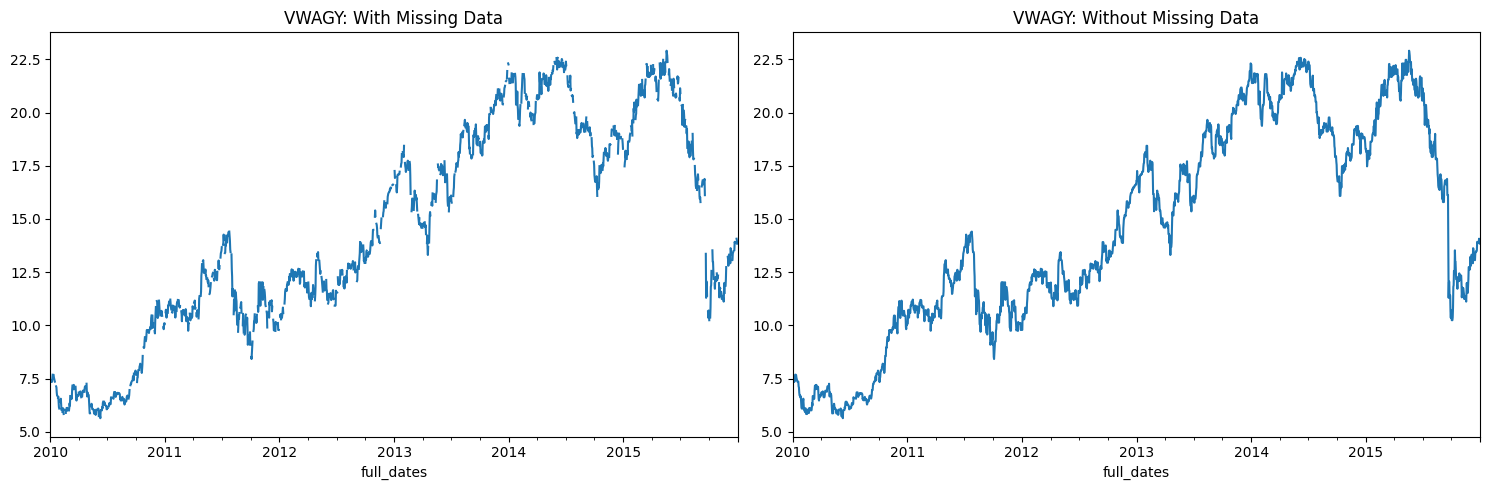

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
adj_close['VWAGY'].plot()
plt.title('VWAGY: With Missing Data')

plt.subplot(1, 2, 2)
adj_close = adj_close.fillna(method='ffill').fillna(method='bfill')
adj_close['VWAGY'].plot()
plt.title('VWAGY: Without Missing Data')
plt.tight_layout()
plt.show()

**Flag before and after emissions announcement**

Create a column to identify the data before and after the emissions scandal announcement.

In [45]:
# Flag before and after emissions announcement
adj_close['emissions_timeframe'] = adj_close.index.map(lambda x: 'pre' if x < post_period[0] else 'post')

# Count the number of days before and after emissions announcement
adj_close.groupby('emissions_timeframe').count().iloc[:,1]

emissions_timeframe
post     103
pre     2088
Name: MXF, dtype: int64

In [46]:
adj_close

A        MXF        MXE       MWA        MVT       MVO  \
full_dates                                                                   
2010-01-01  20.434929   9.431811   6.327004  4.500381   6.702601  5.193464   
2010-01-02  20.434929   9.431811   6.327004  4.500381   6.702601  5.193464   
2010-01-03  20.434929   9.431811   6.327004  4.500381   6.702601  5.193464   
2010-01-04  20.434929   9.431811   6.327004  4.500381   6.702601  5.193464   
2010-01-05  20.212959   9.541288   6.359326  4.467289   6.702601  5.296596   
...               ...        ...        ...       ...        ...       ...   
2015-12-27  39.932854  13.265564  10.648862  7.934443  11.693072  2.663255   
2015-12-28  39.591709  13.241942  10.599607  7.816961  11.743720  2.326893   
2015-12-29  40.141327  13.186834  10.629161  7.898296  11.837785  2.271599   
2015-12-30  39.961281  12.966396  10.540502  7.816961  11.888436  2.110330   
2015-12-31  39.961281  12.966396  10.540502  7.816961  11.888436  2.110330   

                  MUR        MUJ        MUI       MUE        MUC        MUA  \
full_dates                                                                    
2010-01-01  31.663195   6.945591   6.980244  6.513521   6.597368   6.420234   
2010-01-02  31.663195   6.945591   6.980244  6.513521   6.597368   6.420234   
2010-01-03  31.663195   6.945591   6.980244  6.513521   6.597368   6.420234   
2010-01-04  31.663195   6.945591   6.980244  6.513521   6.597368   6.420234   
2010-01-05  32.178471   6.970963   6.990876  6.508520   6.602595   6.483541   
...               ...        ...        ...       ...        ...        ...   
2015-12-27  18.391211  10.414188  10.831230  9.892289  11.142004  10.668198   
2015-12-28  17.619333  10.421508  10.838882  9.929007  11.164662  10.773746   
2015-12-29  17.863497  10.450802  10.792984  9.906977  11.126894  10.841600   
2015-12-30  17.288528  10.524040  10.838882  9.958385  11.187325  10.796365   
2015-12-31  17.288528  10.524040  10.838882  9.958385  11.187325  10.796365   

                  MTZ        MTX        MTW       MTRN        MTR         MTN  \
full_dates                                                                      
2010-01-01  13.120000  26.739090   8.977180  17.805441  13.942924   29.727957   
2010-01-02  13.120000  26.739090   8.977180  17.805441  13.942924   29.727957   
2010-01-03  13.120000  26.739090   8.977180  17.805441  13.942924   29.727957   
2010-01-04  13.120000  26.739090   8.977180  17.805441  13.942924   29.727957   
2010-01-05  12.850000  26.638367   9.639925  18.223104  13.742441   29.785009   
...               ...        ...        ...        ...        ...         ...   
2015-12-27  17.940001  45.860199  13.958839  27.391697   4.277005  113.919823   
2015-12-28  17.510000  45.958210  13.433458  26.946692   4.533259  114.062225   
2015-12-29  17.780001  45.683769  13.714265  27.372757   4.684062  115.993828   
2015-12-30  17.680000  44.733051  13.813906  27.183395   4.296289  115.940430   
2015-12-31  17.680000  44.733051  13.813906  27.183395   4.296289  115.940430   

                  MTH       MTG        MYC        MYD        MYE        MYI  \
full_dates                                                                    
2010-01-01  19.840000  5.854330   6.678409   6.300208   6.529205   6.321567   
2010-01-02  19.840000  5.854330   6.678409   6.300208   6.529205   6.321567   
2010-01-03  19.840000  5.854330   6.678409   6.300208   6.529205   6.321567   
2010-01-04  19.840000  5.854330   6.678409   6.300208   6.529205   6.321567   
2010-01-05  19.969999  6.137147   6.699427   6.290405   6.451978   6.326675   
...               ...       ...        ...        ...        ...        ...   
2015-12-27  34.740002  8.559954  11.888533  10.842697  11.457374  10.863254   
2015-12-28  34.619999  8.456255  11.949028  10.835340  11.729776  10.945269   
2015-12-29  34.860001  8.503390  11.903654  10.908898  11.828829  10.870711   
2015-12-30  34.380001  8.399690  11.933905  10.886826 

# Exploratory data analysis

**Summary statistics grouped by pre and post periods**

In [47]:
adj_close[['VWAGY', 'emissions_timeframe']].groupby('emissions_timeframe').describe().T

emissions_timeframe        post          pre
VWAGY count          103.000000  2088.000000
      mean            12.371941    14.606269
      std              1.071172     5.007241
      min             10.239859     5.634551
      25%             11.522615    10.686848
      50%             12.257205    14.283364
      75%             13.315811    19.108039
      max             16.116571    22.905415

Text(0.5, 1.0, 'VWAGY: 7 Day Rolling Average')

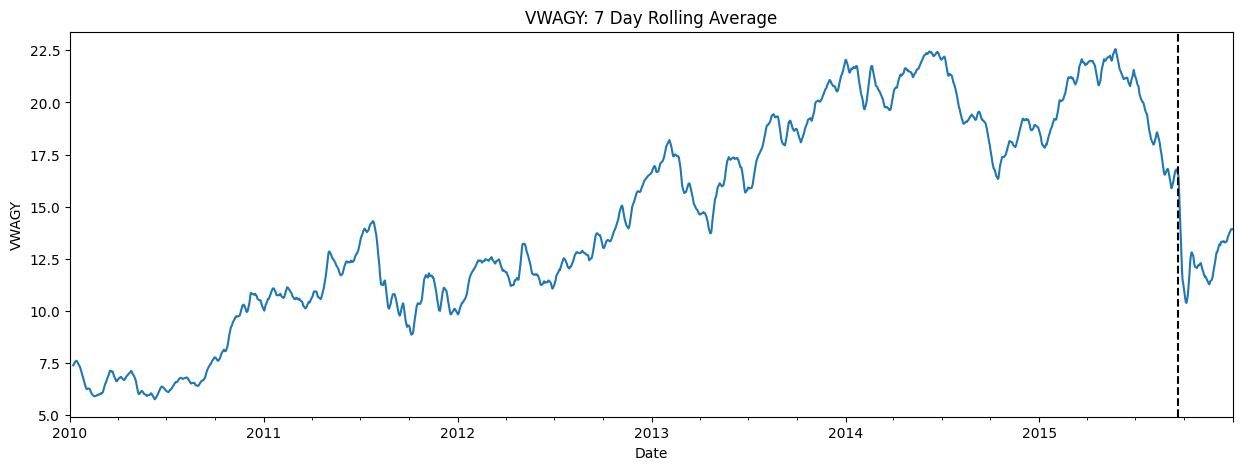

In [48]:
# Plot 7 day rolling average with vertical line marking the date of the emissions scandal.
plt.figure(figsize=(15,5))
adj_close['VWAGY'].rolling(7).mean().plot()
plt.axvline(post_period[0], color='black', linestyle='--',)
plt.xlabel('Date')
plt.ylabel('VWAGY')
plt.title('VWAGY: 7 Day Rolling Average')

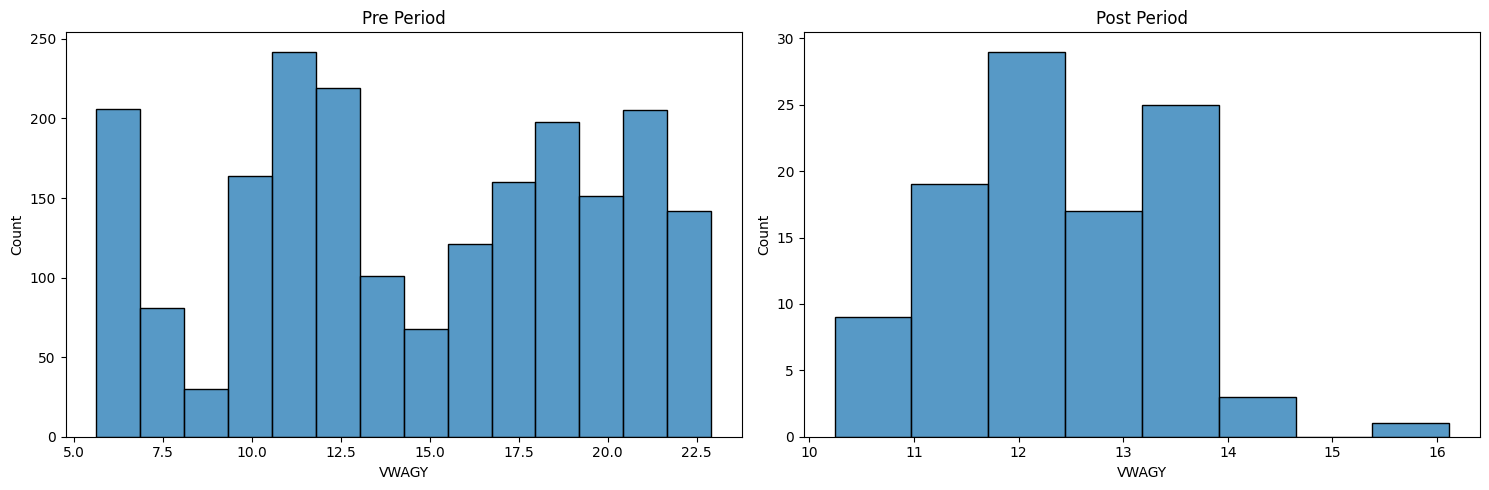

In [49]:
# Plot the distribution of the Volkswagen stock price in the pre and post periods
volks_pre = adj_close[adj_close['emissions_timeframe'] == 'pre']['VWAGY']
volks_post = adj_close[adj_close['emissions_timeframe'] == 'post']['VWAGY']

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(volks_pre)
plt.title('Pre Period')

plt.subplot(1, 2, 2)
sns.histplot(volks_post)
plt.title('Post Period')
plt.tight_layout()
plt.show()

**Correlation**

Find stocks that are correlated with Volkswagen in the pre period. Use those stocks to build counterfactual in the post period.

In [50]:
adj_close1 = adj_close.copy()

In [53]:
corr_pre = adj_close[adj_close['emissions_timeframe'] == 'pre'].corr().abs()
corr_pre = corr_pre['VWAGY'].sort_values(ascending=False)
vwagy_corr = list(corr_pre[corr_pre > 0.95].index)
print(f'There are {len(vwagy_corr)} stocks that correlate with VWAGY in the pre period')

# Filter dataset to only include stocks that correlate with Volkswagen in the pre period
adj_close = adj_close[vwagy_corr + ['emissions_timeframe']]
print('Shape of filtered dataset:', adj_close.shape)

<ipython-input-53-e03d58ee6b71>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_pre = adj_close[adj_close['emissions_timeframe'] == 'pre'].corr().abs()


There are 17 stocks that correlate with VWAGY in the pre period
Shape of filtered dataset: (2191, 18)


# Time series forecasting

**Facebook Prophet**

Facebook Prophet decomposes time series data into its components (daily, weekly, yearly, etc.). I'll use Prophet to identify seasonal trends in the pre period for the VWAGY stock price, and use that seasonal trend as another predictor for building the counterfactual.

In [54]:
# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [55]:
# Filter to VWAGY and make the date index a column
fb_data = adj_close['VWAGY'].reset_index()

# Columns need to be named 'ds' and 'y' for Prophet
fb_data.columns = ['ds', 'y']

# Separate pre and post periods
fb_data_pre = fb_data[fb_data['ds'] <= pre_period[1]]
fb_data_post = fb_data[fb_data['ds'] > pre_period[1]]

# Fit model using pre period data
with suppress_stdout_stderr():
        fb = Prophet().fit(fb_data_pre)

# fb = Prophet()
# fb.fit(fb_data_pre)

# Forecast
num_forecast_days = 1 + (post_period[1] - post_period[0]).days
future = fb.make_future_dataframe(periods=103)
forecast = fb.predict(future)

# Grab the seasonal trend and date columns
fb_trend = forecast[['ds', 'trend']]
fb_trend.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6hwyh9z/lcw2em_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6hwyh9z/1uum05nr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70105', 'data', 'file=/tmp/tmpo6hwyh9z/lcw2em_2.json', 'init=/tmp/tmpo6hwyh9z/1uum05nr.json', 'output', 'file=/tmp/tmpo6hwyh9z/prophet_model15xo0zcy/prophet_model-20230421220457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend
0,2010-01-01,6.323910
1,2010-01-02,6.317105
2,2010-01-03,6.310299
3,2010-01-04,6.303494
4,2010-01-05,6.296689


In [56]:
# Join the seasonal trend data to the adjusted close data
adj_close = adj_close.merge(fb_trend, left_index=True, right_on='ds', how='inner')
adj_close.set_index('ds', inplace=True)

**Google CausalImpact**

CausalImpact is a Bayesian time series model. The model learns the relationship between covariates (other stock prices) and the target variable (Volkswagen stock price) in the pre period. Given the covariates in the post period, the model forecasts what would have happened to the target variable if the intervention did not happen (counterfactual). It's important the covariates are not affected by the intervention, which is true in this case because the intervention is Volkswagen announcing that they lied about their vehicle emissions.

In [57]:
adj_close

,VWAGY,GAB,AME,EMN,ETN,SPE,GGG,AMG,RVT,MFD,FC,KAMN,NFJ,LGI,HOG,GDV,ASGN,emissions_timeframe,trend
ds,,,,,,,,,,,,,,,,,,,
2010-01-01,7.353887,1.512928,15.882857,22.810036,12.950365,6.000300,7.841926,66.747307,4.143435,4.185970,6.230000,19.130356,5.174665,5.531540,19.587940,6.101944,7.400000,pre,6.323910
2010-01-02,7.353887,1.512928,15.882857,22.810036,12.950365,6.000300,7.841926,66.747307,4.143435,4.185970,6.230000,19.130356,5.174665,5.531540,19.587940,6.101944,7.400000,pre,6.317105
2010-01-03,7.353887,1.512928,15.882857,22.810036,12.950365,6.000300,7.841926,66.747307,4.143435,4.185970,6.230000,19.130356,5.174665,5.531540,19.587940,6.101944,7.400000,pre,6.310299
2010-01-04,7.353887,1.512928,15.882857,22.810036,12.950365,6.000300,7.841926,66.747307,4.143435,4.185970,6.230000,19.130356,5.174665,5.531540,19.587940,6.101944,7.400000,pre,6.303494
2010-01-05,7.405192,1.518827,15.812899,22.518215,12.873857,5.996037,7.781031,67.280281,4.177369,4.245911,6.200000,19.000051,5.230456,5.652587,19.734127,6.161364,7.190000,pre,6.296689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,13.890612,2.909181,52.120979,57.901852,26.478548,8.020034,21.925982,158.050034,7.058308,6.553016,16.540001,37.765129,7.809461,7.287458,38.974079,12.622597,44.759998,post,18.884581
2015-12-28,14.070374,2.876616,51.784950,57.313644,26.150360,8.063318,21.946934,158.195374,7.094444,6.519976,16.719999,37.519253,7.778175,7.259430,38.653160,12.622597,44.889999,post,18.882015
2015-12-29,13.986041,2.903754,52.370583,58.036259,26.394011,8.106604,21.905037,157.623627,7.124556,6.519976,16.920000,37.956367,7.853264,7.343518,38.864292,12.656560,45.830002,post,18.879450


In [58]:
# CausalImpact needs the target variable in the first column
ci_data = adj_close[['VWAGY', 'GAB', 'AME', 'EMN', 'ETN', 'SPE', 'GGG', 'AMG', 'RVT', 'MFD',
       'FC', 'KAMN', 'NFJ', 'LGI', 'HOG', 'GDV', 'ASGN', 'trend']]

# Fit model
ci = CausalImpact(ci_data, pre_period, post_period)
ci.run()

In [60]:
print(ci.summary())

                                Average       Cumulative
Actual                               12             1274
Predicted                            16             1680
95% CI                         [13, 18]     [1432, 1927]
                                                        
Absolute Effect                      -3             -405
95% CI                         [-1, -6]     [-157, -653]
                                                        
Relative Effect                  -24.2%           -24.2%
95% CI                  [-9.4%, -38.9%]  [-9.4%, -38.9%]
                                                        
P-value                            0.0%                 
Prob. of Causal Effect           100.0%                 
None


**Interpreting the above results**

* The actual average outcome was 12, while the predicted average outcome was 16.

* The actual cumulative outcome was 1274, while the predicted cumulative outcome was 1680.

* The 95% confidence interval for the actual average outcome is between 13 and 18, and the 95% confidence interval for the actual cumulative outcome is between 1432 and 1927.

* The absolute effect of the intervention is -3 for the average outcome and -405 for the cumulative outcome, meaning that the intervention resulted in a decrease of 3 units for the average outcome and 405 units for the cumulative outcome.

* The 95% confidence interval for the absolute effect is between -1 and -6 for the average outcome, and between -157 and -653 for the cumulative outcome.

* The relative effect of the intervention is -24.2% for both the average and cumulative outcomes, meaning that the intervention resulted in a 24.2% decrease in both the average and cumulative outcomes.

* The 95% confidence interval for the relative effect is between -9.4% and -38.9% for both the average and cumulative outcomes.

* The p-value is less than 0.05, indicating that the observed effect is statistically significant.

* The probability of a causal effect is 100%, indicating a high level of confidence that the intervention caused the observed effect.


In summary, the intervention resulted in a statistically significant decrease in both the average and cumulative outcomes, with a high level of confidence that the intervention caused the observed effect.








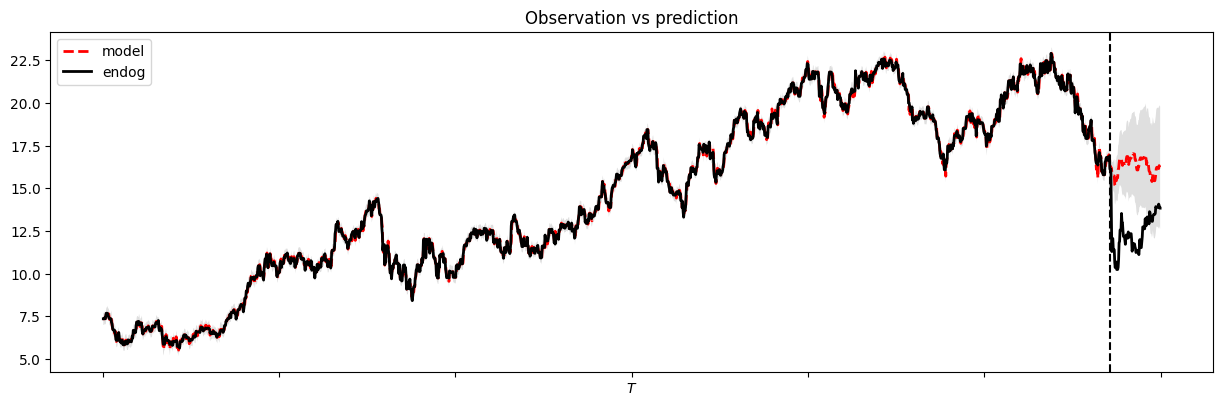

In [61]:
# This graph shows the empirical and counterfactual data
ci.plot(panels=['original'], figsize=(15,15))

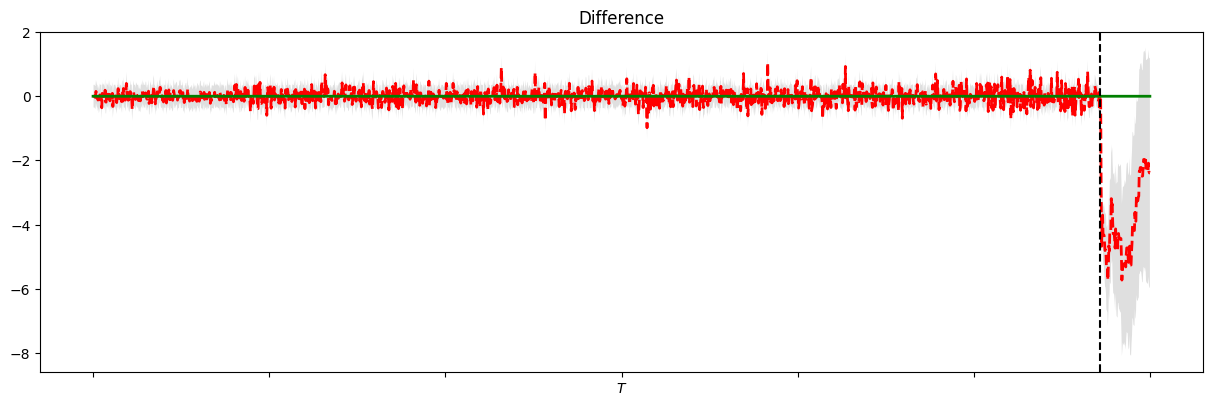

In [62]:
# This graph shows the difference between the empirical and counterfactual data
ci.plot(panels=['pointwise'], figsize=(15,15))

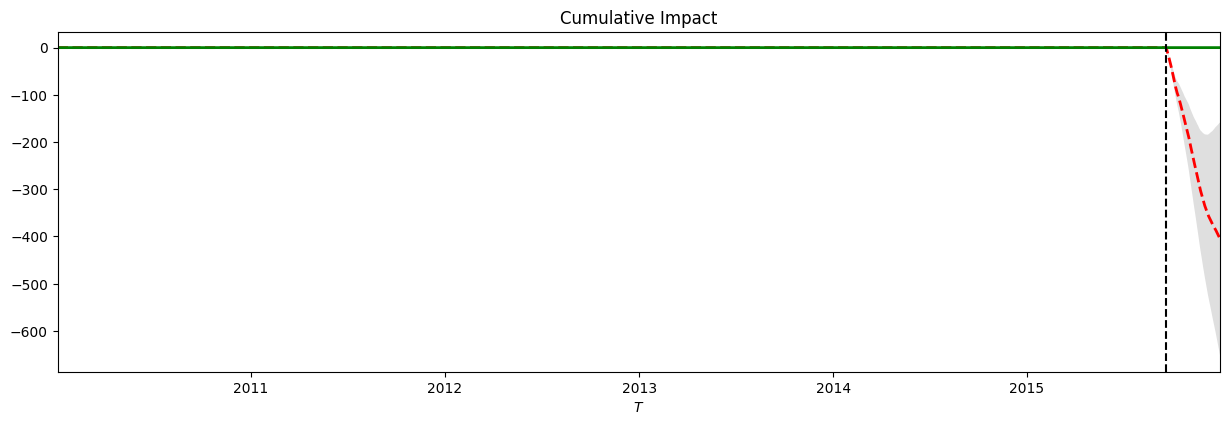

In [63]:
# This graph shows the cumulative difference between the empirical and counterfactual data in the post period
ci.plot(panels=['cumulative'], figsize=(15,15))

# Conclusion

Volkswagen's announcement that they lied about their vehicle emissions caused their stock price to drop by 24% during the rest of the year 2016 (CausalImpact relative effect). The percent decrease in stock price is equivalent to 4 dollars less each day (CausalImpact absolute effect), which is a substantial decrease considering their average stock price in the pre period was 14.6 dollars. The biggest drop in stock price occurred in the two weeks following their announcement. The stock price started to recover in December 2015, but was still much less than what it would have been.